In [1]:
# Import the classes
from thesisv3.classism import MusicFileManager, MusicSegmentAnalyzer, MusicVisualizer

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\School\thesisv3\.venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
file_manager = MusicFileManager()
file_manager.display_selector()

In [3]:
analyzer = MusicSegmentAnalyzer()

In [4]:
analyzer.load_score(file_manager.selected_file)

In [5]:
analyzer.analyze_segments()

In [6]:
analyzer.preprocess_segments()

In [7]:
analyzer.ir_symbols

[(<music21.note.Note D>, 'M', 'pink'),
 (<music21.note.Note G>, 'P', 'blue'),
 (<music21.note.Note A>, 'P', 'blue'),
 (<music21.note.Note B>, 'P', 'blue'),
 (<music21.note.Note C>, 'VR', 'yellow'),
 (<music21.note.Note D>, 'VR', 'yellow'),
 (<music21.note.Note G>, 'VR', 'yellow'),
 (<music21.note.Note G>, 'd', 'lime'),
 (<music21.note.Note E>, 'd', 'lime'),
 (<music21.note.Note C>, 'P', 'blue'),
 (<music21.note.Note D>, 'P', 'blue'),
 (<music21.note.Note E>, 'P', 'blue'),
 (<music21.note.Note F#>, 'VR', 'yellow'),
 (<music21.note.Note G>, 'VR', 'yellow'),
 (<music21.note.Note G>, 'VR', 'yellow'),
 (<music21.note.Note G>, 'd', 'lime'),
 (<music21.note.Note C>, 'd', 'lime'),
 (<music21.note.Note D>, 'P', 'blue'),
 (<music21.note.Note C>, 'P', 'blue'),
 (<music21.note.Note B>, 'P', 'blue'),
 (<music21.note.Note A>, 'd', 'lime'),
 (<music21.note.Note B>, 'd', 'lime'),
 (<music21.note.Note C>, 'P', 'blue'),
 (<music21.note.Note B>, 'P', 'blue'),
 (<music21.note.Note A>, 'P', 'blue'),
 (<mus

In [8]:
# analyzer.calculate_distance_matrix()

In [8]:
visualizer = MusicVisualizer(analyzer)

In [28]:
def visualize_notes_with_symbols(notes_with_symbols, original_score, all_parts=False):
    """
    Visualizes notes with their assigned IR symbols and colors in a music21 score.
    
    Parameters:
        notes_with_symbols (list): A list of tuples containing (element, symbol, color).
        original_score (music21.stream.Score): The original score used as template.
    
    Returns:
        music21.stream.Score: A new score with annotated symbols and colors.
    """
    # Make a deep copy of the original score to preserve its structure
    new_score = copy.deepcopy(original_score)
    parts_to_process = new_score.parts if all_parts else [new_score.parts[0]]
    
    # Create an iterator over the provided symbols list
    symbols_iter = iter(notes_with_symbols)
    
    for part in parts_to_process:
        for measure in part.getElementsByClass(stream.Measure):
            # Process each element in the measure
            for element in measure:
                # If the element is a Voice, process its subelements.
                if isinstance(element, stream.Voice):
                    if (element.id is not None and element.id != '1'):
                        continue
                    for subelement in element.flatten().getElementsByClass([note.Note, note.Rest, chord.Chord]):
                        try:
                            symbol_element, symbol, color = next(symbols_iter)
                            # Apply color and add lyric if the elements match.
                            if subelement == symbol_element:
                                subelement.style.color = color
                                subelement.lyric = symbol
                            else:
                                print(f"Expected: {symbol_element}, Found: {element}")
                        except StopIteration:
                            print(f"stopping {element}")
                            break  # No more symbols to assign.
                # Process standalone elements (notes, rests, chords).
                elif isinstance(element, (note.Note, note.Rest, chord.Chord)):
                    try:
                        symbol_element, symbol, color = next(symbols_iter)
                        if element == symbol_element:
                            element.style.color = color
                            element.lyric = symbol
                        else:
                            print(f"Expected: {symbol_element}, Found: {element}")
                    except StopIteration:
                        print(f"stopping {element}")
                        break
                else:
                    print(element)
    return new_score

In [29]:
test = iter(analyzer.ir_symbols)
next(test)

(<music21.note.Note D>, 'M', 'pink')

<music21.layout.SystemLayout>
<music21.clef.TrebleClef>
<music21.key.KeySignature of 1 sharp>
<music21.meter.TimeSignature 3/4>
<music21.layout.SystemLayout>
<music21.layout.SystemLayout>
<music21.bar.Repeat direction=end>
<music21.bar.Repeat direction=start>
<music21.layout.SystemLayout>
<music21.layout.SystemLayout>
<music21.bar.Repeat direction=end>


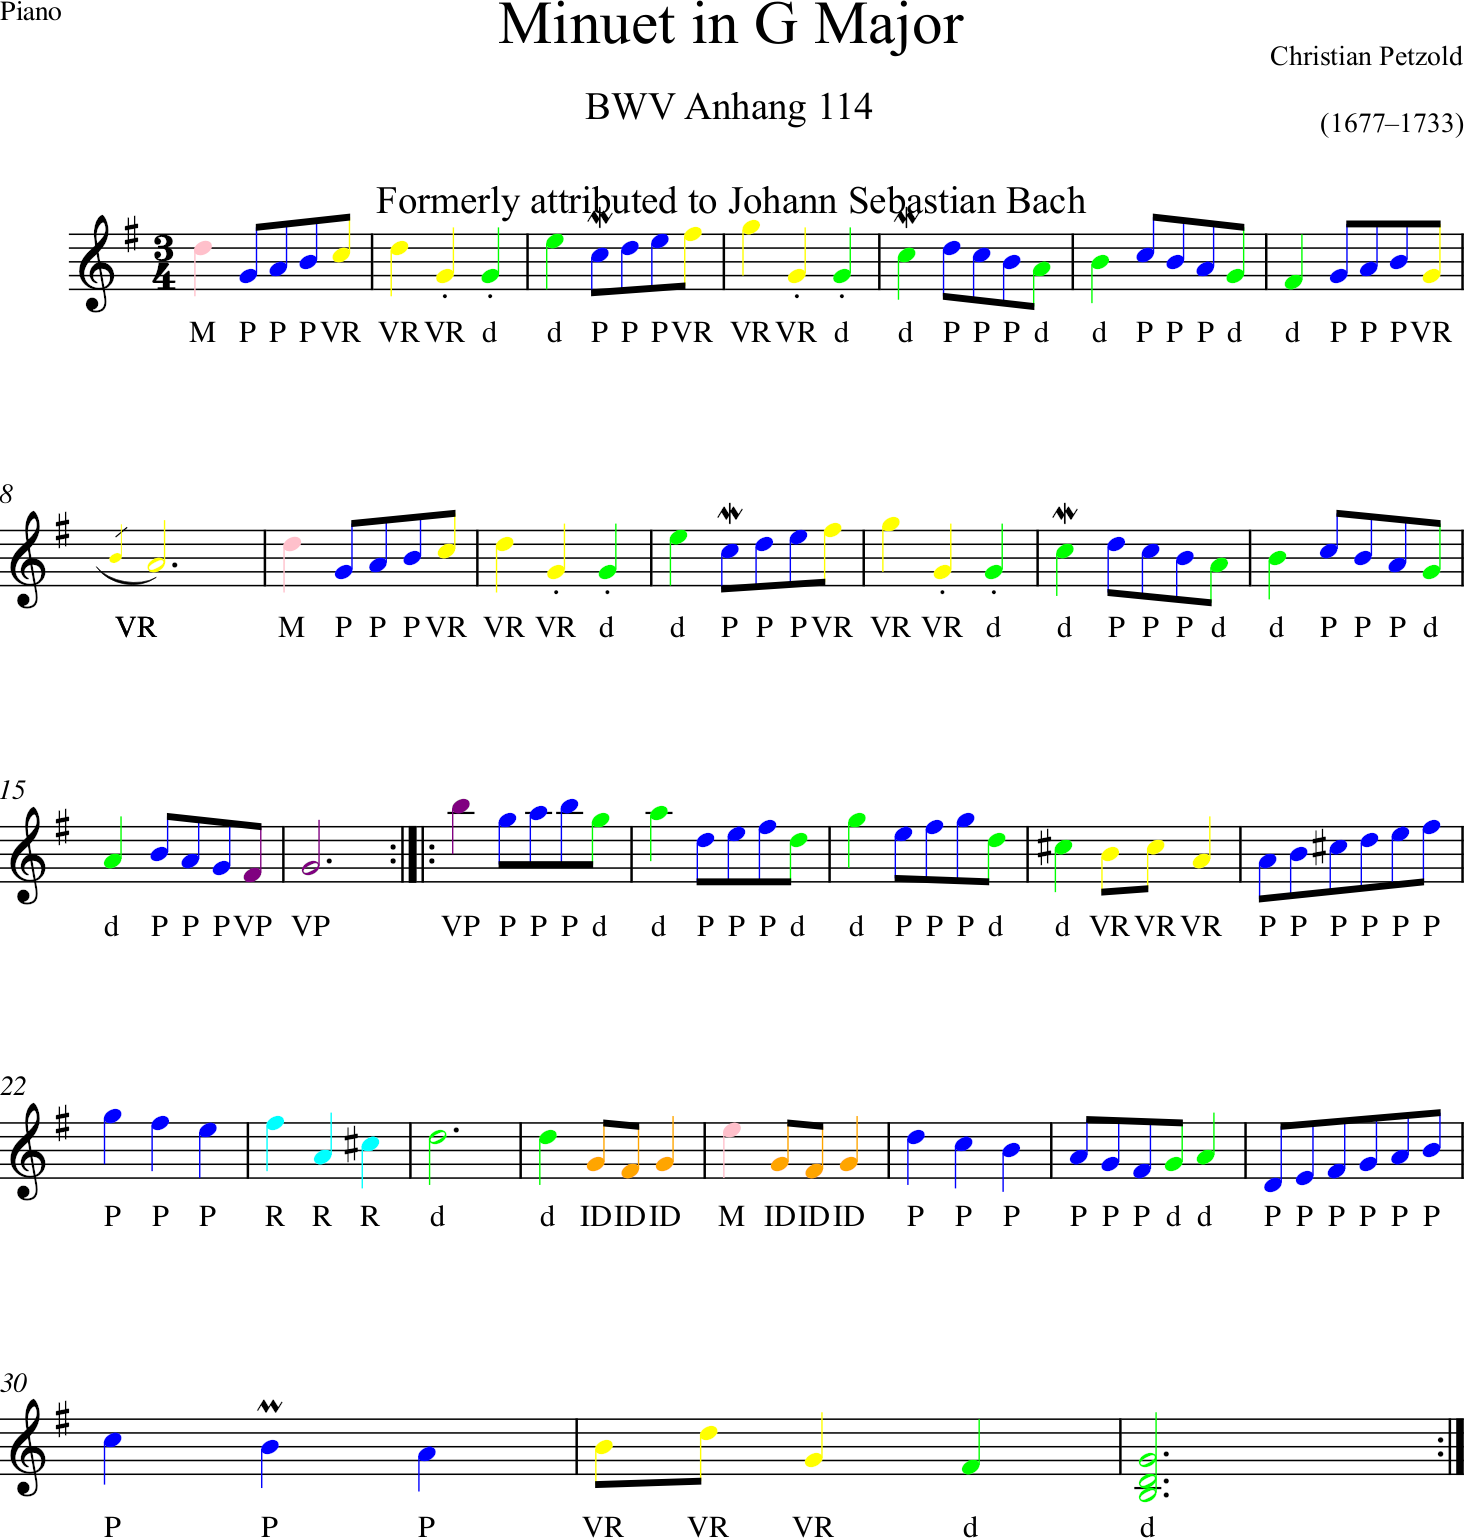

In [30]:
import copy
from music21 import *
visualize_notes_with_symbols(analyzer.ir_symbols, analyzer.parsed_score).show()

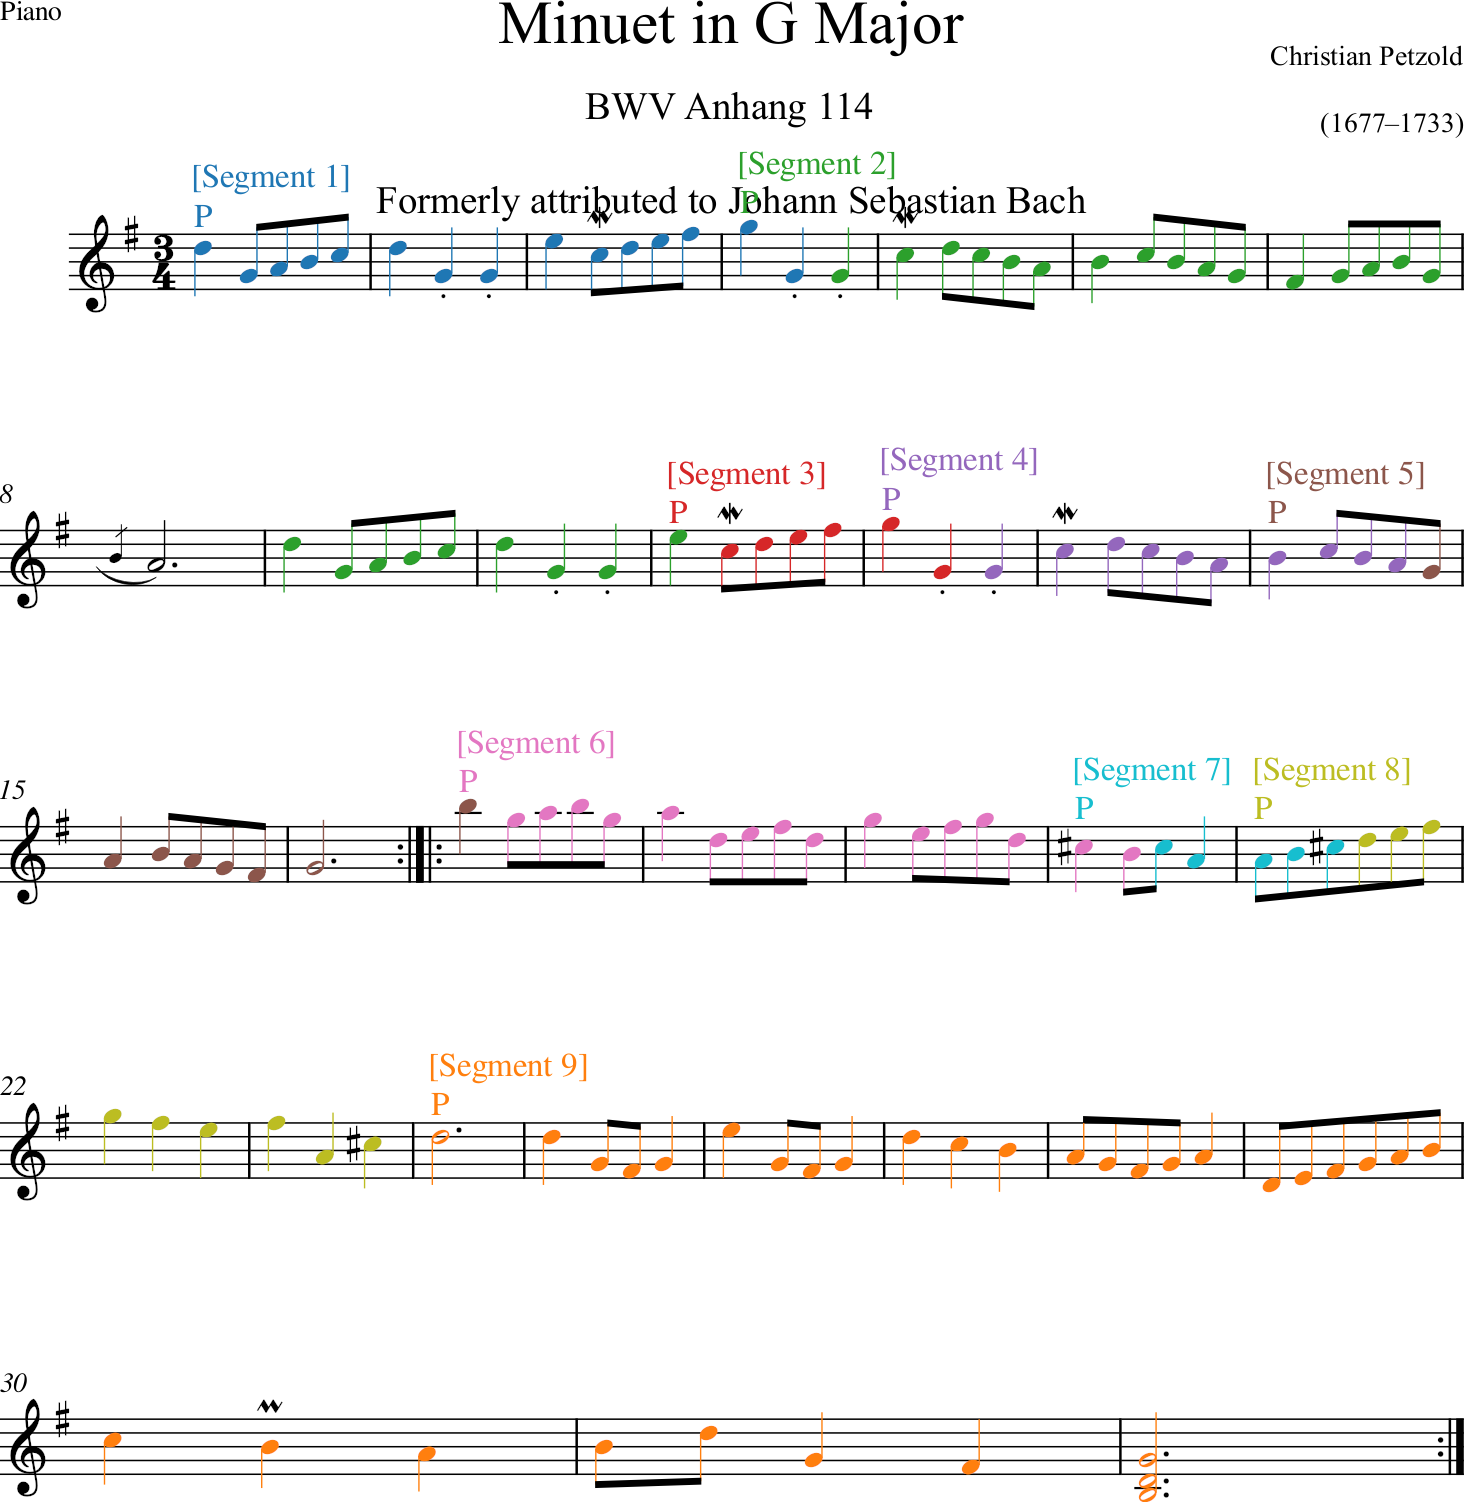

In [42]:
visualizer.visualize_colored_segments()

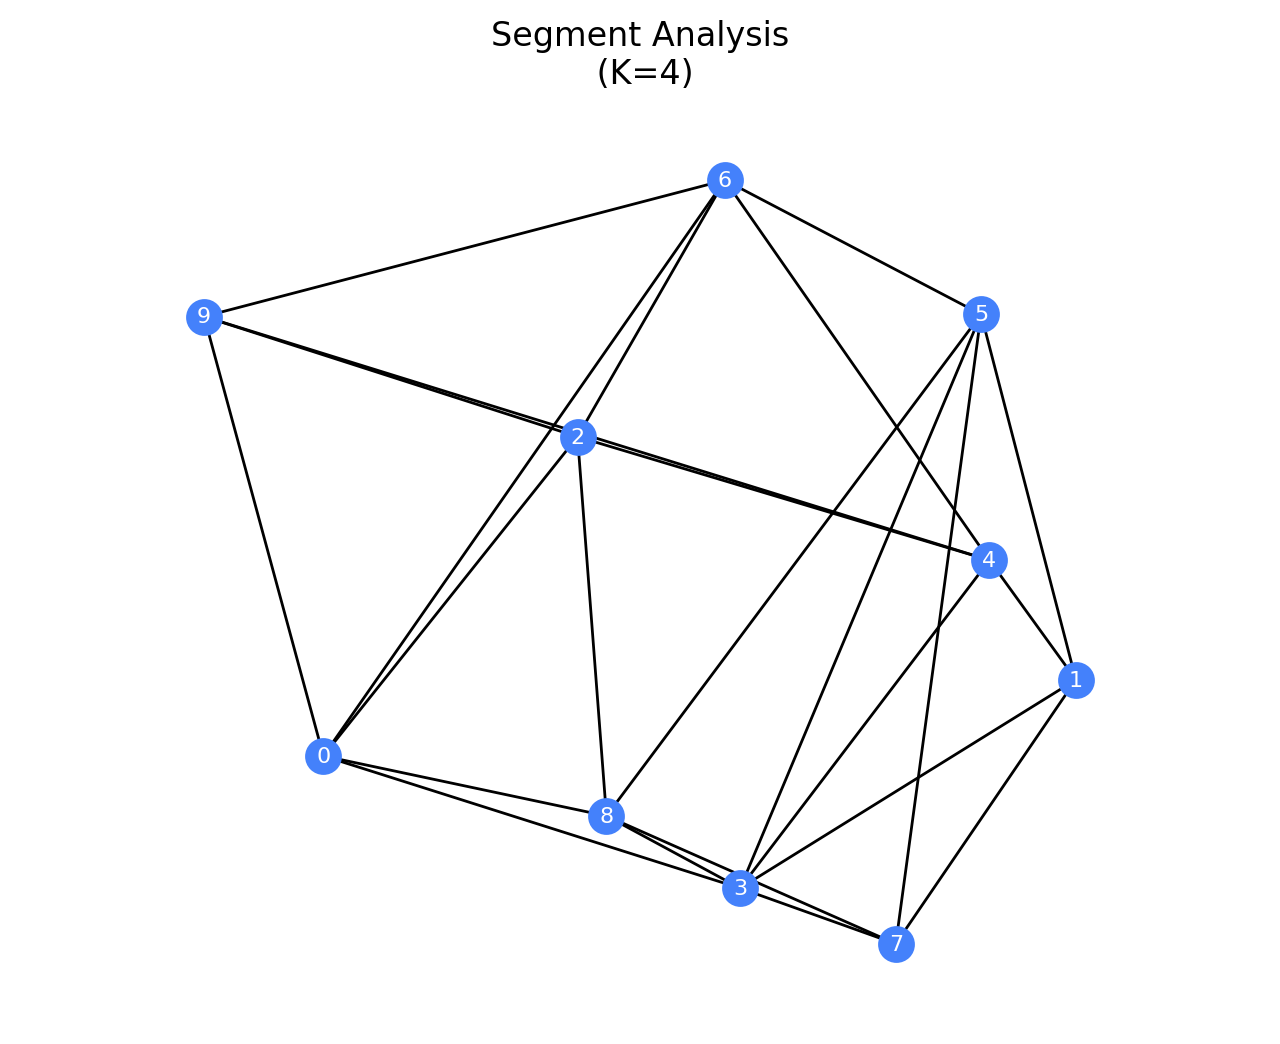

In [11]:
visualizer.visualize_knn_graph(k=4, title="Segment Analysis")

In [12]:
import numpy as np

def ismonophonic(nmat):
    """
    A simple check that the note matrix is monophonic.
    This version assumes that nmat is sorted by onset time and that
    the first two columns contain the note onset and offset.
    It returns False if any note overlaps the previous one.
    """
    if nmat.shape[0] < 2:
        return True
    # Assuming column 0 = onset and column 1 = offset
    for i in range(1, nmat.shape[0]):
        if nmat[i, 0] < nmat[i-1, 1]:
            return False
    return True

def mobility(nmat):
    """
    Compute the melodic mobility measure (von Hippel, 2000)
    for a notematrix. The mobility is computed using the lag‐1 
    autocorrelation of the pitch deviations from a running mean.
    
    Parameters
    ----------
    nmat : numpy.ndarray
        The note matrix. It is assumed that each row is a note,
        and that the pitch is stored in column 3 (i.e. index 2).
    
    Returns
    -------
    y : numpy.ndarray
        A column vector (2D array) of nonnegative mobility values,
        one value per note (with a zero prepended). (Because the 
        MATLAB code sets the first two values to zero, note that
        y[0]==y[1]==0.)
    
    Note
    ----
    Since the autocorrelation is always between -1 and 1 and the 
    pitch difference (in semitones) is used as a multiplier, the 
    mobility value (after taking the absolute value) is nonnegative.
    In theory its range is [0, ∞) but if pitches are MIDI numbers 
    (0–127) then the mobility will be bounded roughly by that range.
    """
    if nmat.size == 0:
        return np.array([])
    
    if not ismonophonic(nmat):
        print("mobility works only with monophonic input!")
        return np.array([])
    
    # Extract the pitch vector (assuming pitch is in column 3, i.e. index 2)
    pitches = nmat[:, 2]
    N = len(pitches)
    
    # Initialize lists to hold intermediate values.
    m_values = []  # running means for notes 1 to i-1
    p_list = []    # deviations for the previous note(s)
    # p2_list will be a list of length N; we set p2_list[0]=0
    p2_list = [0] * N  
    mob = [0] * N      # Will hold the lag‐1 correlation values (for indices 1..N-1)
    y = [0] * N        # Will hold the computed mobility values
    
    # Loop from i=1 to N-1 (which corresponds to MATLAB’s i=2:N)
    for i in range(1, N):
        # Compute the mean of all previous pitches (notes 0 to i-1)
        m_val = np.mean(pitches[:i])
        m_values.append(m_val)
        # Compute the deviation of the (i-1)th note from this mean.
        p_val = pitches[i-1] - m_val
        p_list.append(p_val)
        # Store this deviation in p2_list at index i
        p2_list[i] = p_val
        # In the MATLAB code, the vector z is created by concatenating p with
        # the current p_val again (i.e. duplicating the last element)
        z = p_list + [p_list[-1]]
        # Now take the first (i+1) elements of p2_list and z to form a 2-column array.
        p2_sub = np.array(p2_list[:i+1])
        z_sub = np.array(z)
        # Compute the correlation coefficient between p2_sub and z_sub.
        # If the standard deviation is zero (so the correlation is undefined), set r = 0.
        if np.std(p2_sub) == 0 or np.std(z_sub) == 0:
            r = 0
        else:
            r = np.corrcoef(p2_sub, z_sub)[0, 1]
        mob[i] = r
        # Compute the mobility value for the (i-1)th note.
        # (Note: The MATLAB code uses mob(i-1), which for i==1 is not defined,
        # so we use 0 in that case.)
        y[i-1] = mob[i-1] * (pitches[i] - m_val) if i-1 >= 0 else 0

    # After the loop, the MATLAB code sets the second element to 0
    if len(y) > 1:
        y[1] = 0
    # Prepend a 0 (so that the returned vector has one more element than computed in the loop)
    y = [0] + y
    # Finally, take the absolute value (to ensure nonnegative ratings)
    y = np.abs(np.array(y))
    # Return as a column vector
    return y.reshape(-1, 1)

# ---------------------------
# Example usage:
if __name__ == '__main__':
    # Create a simple example notematrix.
    # Here each row is a note with columns:
    # [onset, offset, pitch, ...]  (other columns may follow)
    # For example, we make a monophonic melody with 5 notes:
    nmat = np.array([
        [0.0, 0.5, 60],
        [0.6, 1.0, 62],
        [1.1, 1.5, 64],
        [1.6, 2.0, 65],
        [2.1, 2.5, 63]
    ])
    
    y = mobility(nmat)
    print("Mobility values:\n", y)


Mobility values:
 [[0.        ]
 [0.        ]
 [0.        ]
 [1.5       ]
 [0.20454545]
 [0.        ]]


In [15]:
def calculate_ir_symbol_old(interval1, interval2, threshold=5):
    """
    Calculates the IR (Intervallic Relationship) symbol based on the intervals between notes.

    Parameters:
    interval1 (int): The interval between the first and second notes.
    interval2 (int): The interval between the second and third notes.
    threshold (int): The threshold value for determining the type of relationship.

    Returns:
    str: The IR symbol representing the relationship between the intervals.
    """
    direction = interval1 * interval2
    abs_difference = abs(interval2 - interval1)

    if direction > 0 and abs_difference < threshold:
        return 'P'  # Process
    elif interval1 == interval2 == 0:
        return 'D'  # Duplication
    elif (interval1 * interval2 < 0) and (-threshold <= abs(abs_difference) <= threshold) and (abs(interval2) != abs(interval1)):
        return 'IP'  # Intervallic Process
    elif (interval1 * interval2 < 0) and (abs(interval2) == abs(interval1)):
        return 'ID'  # Intervallic Duplication
    elif (interval1 * interval2 > 0) and (abs_difference >= threshold) and (abs(interval1) <= threshold):
        return 'VP'  # Vector Process
    elif (interval1 * interval2 < 0) and (abs(abs_difference) >= threshold) and (abs(interval1) >= threshold):
        return 'R'  # Reversal
    elif (interval1 * interval2 > 0) and (abs(abs_difference) >= threshold) and (abs(interval1) >= threshold):
        return 'IR'  # Intervallic Reversal
    elif (interval1 * interval2 < 0) and (abs_difference >= threshold) and (abs(interval1) <= threshold):
        return 'VR'  # Vector Reversal
    elif interval2 == 0 and not (interval1 < -5 or interval1 > 5):
        return 'IP'
    elif interval2 == 0 and (interval1 < -5 or interval1 > 5):
        return 'R'
    elif interval1 == 0 and not (interval2 < -5 or interval2 > 5):
        return 'P'
    elif interval1 == 0 and (interval2 < -5 or interval2 > 5):
        return 'VR'


In [11]:
from music21 import chord, note
from thesisv3.preprocessing.preprocessing import calculate_ir_symbol
from thesisv3.analysis.visualization import visualize_notes_with_symbols

def assign_ir_symbols_old(note_array):
    """
    Assigns IR symbols and colors to each element in the score array.

    Parameters:
    score_array (list): A list of music21 note and chord elements.

    Returns:
    list: A list of tuples containing each element, its IR symbol, and its color.
    """
    symbols = []
    current_group = []
    group_pitches = []

    color_map = {
        'P': 'blue',  # IR1: P (Process)
        'D': 'green',  # IR2: D (Duplication)
        'IP': 'red',  # IR3: IP (Intervallic Process)
        'ID': 'orange',  # IR4: ID (Intervallic Duplication)
        'VP': 'purple',  # IR5: VP (Vector Process)
        'R': 'cyan',  # IR6: R (Reversal)
        'IR': 'magenta',  # IR7: IR (Intervallic Reversal)
        'VR': 'yellow',  # IR8: VR (Vector Reversal)
        'M': 'pink',  # IR9: M (Monad)
        'd': 'lime',  # IR10 d (Dyad)
    }

    def evaluate_current_group():
        if len(current_group) == 3:
            interval1 = group_pitches[1] - group_pitches[0]
            interval2 = group_pitches[2] - group_pitches[1]
            symbol = calculate_ir_symbol_old(interval1, interval2)
            color = color_map.get(symbol, 'black')  # Default to black if symbol is not predefined
            symbols.extend([(note, symbol, color) for note in current_group])
        elif len(current_group) == 2:
            symbols.extend([(note, 'd', color_map['d']) for note in current_group])  # Dyad
        elif len(current_group) == 1:
            symbols.extend([(note, 'M', color_map['M']) for note in current_group])  # Monad
        current_group.clear()
        group_pitches.clear()

    for element in note_array:
        if isinstance(element, note.Note):
            current_group.append(element)
            group_pitches.append(element.pitch.ps)
            if len(current_group) == 3:
                evaluate_current_group()
        elif isinstance(element, chord.Chord):
            current_group.append(element)
            group_pitches.append(element.root().ps)
            if len(current_group) == 3:
                evaluate_current_group()
        elif isinstance(element, note.Rest):
            rest_tuple = (element, 'rest', 'black')
            evaluate_current_group()
            symbols.append(rest_tuple)
        else:
            if current_group:
                evaluate_current_group()

    # Handle any remaining notes
    if current_group:
        evaluate_current_group()

    return symbols

In [10]:
from music21 import stream

def visualize_notes_with_symbols_old(notes_with_symbols):
    """
    Visualizes notes with their assigned IR symbols and colors in a music21 score.

    Parameters:
    notes_with_symbols (list): A list of tuples containing each note, its IR symbol, and its color.

    Returns:
    None
    """
    s = stream.Score()
    part = stream.Part()
    for note, symbol, color in notes_with_symbols:
        note.style.color = color
        note.lyric = symbol
        part.append(note)
    s.append(part)
    s.show()

In [18]:
def assign_ir_symbols_new(note_array):
    """
    Assigns IR symbols and colors to each element in the score array.

    Parameters:
    score_array (list): A list of music21 note and chord elements.

    Returns:
    list: A list of tuples containing each element, its IR symbol, and its color.
    """
    symbols = []
    current_group = []
    group_pitches = []
    last_beam_status = None

    color_map = {
        'P': 'blue',  # IR1: P (Process)
        'D': 'green',  # IR2: D (Duplication)
        'IP': 'red',  # IR3: IP (Intervallic Process)
        'ID': 'orange',  # IR4: ID (Intervallic Duplication)
        'VP': 'purple',  # IR5: VP (Vector Process)
        'R': 'cyan',  # IR6: R (Reversal)
        'IR': 'magenta',  # IR7: IR (Intervallic Reversal)
        'VR': 'yellow',  # IR8: VR (Vector Reversal)
        'M': 'pink',  # IR9: M (Monad)
        'd': 'lime',  # IR10 d (Dyad)
    }

    def evaluate_current_group():
        if len(current_group) >= 3:
            interval1 = group_pitches[1] - group_pitches[0]
            interval2 = group_pitches[2] - group_pitches[1]
            symbol = calculate_ir_symbol(interval1, interval2)
            color = color_map.get(symbol, 'black')  # Default to black if symbol is not predefined
            symbols.extend([(note, symbol, color) for note in current_group])
        elif len(current_group) == 2:
            symbols.extend([(note, 'd', color_map['d']) for note in current_group])  # Dyad
        elif len(current_group) == 1:
            symbols.extend([(note, 'M', color_map['M']) for note in current_group])  # Monad
        current_group.clear()
        group_pitches.clear()

    def get_beam_status(e):
        if not isinstance(e, (note.Note, chord.Chord)):
            return None
        beam_status = 'single'  # Default status for unbeamed notes
        if e.beams:
            # Get beam types
            beam_types = [beam.type for beam in e.beams.beamsList]
            if 'start' in beam_types:
                beam_status = 'start'
            elif 'continue' in beam_types:
                beam_status = 'continue'
            elif 'stop' in beam_types:
                beam_status = 'stop'
            elif 'partial' in beam_types:
                beam_status = 'partial'
        return beam_status

    num_notes = len(note_array)
    i = 0
    while i < num_notes:
        element = note_array[i]
        if isinstance(element, (note.Note, chord.Chord)):
            # Get beam status
            beam_status = get_beam_status(element)
            current_group.append(element)
            if isinstance(element, note.Note):
                group_pitches.append(element.pitch.ps)
            elif isinstance(element, chord.Chord):
                group_pitches.append(element.root().ps)

            # BEAM
            if (last_beam_status in ['start', 'continue', 'partial']) and (
                    beam_status in ['continue', 'stop', 'partial']):
                if beam_status == 'stop':

                    # TODO: REVISIT IF IT IS WEIRD
                    if len(current_group) == 2:
                        i += 1
                        element2 = note_array[i]
                        if isinstance(element2, (note.Note, chord.Chord)):
                            # Get beam status
                            beam_status = get_beam_status(element2)
                            current_group.append(element2)
                            if isinstance(element2, note.Note):
                                group_pitches.append(element2.pitch.ps)
                            elif isinstance(element2, chord.Chord):
                                group_pitches.append(element2.root().ps)
                        elif isinstance(element, note.Rest):
                            rest_tuple = (element, 'rest', 'black')
                            evaluate_current_group()
                            symbols.append(rest_tuple)
                        else:
                            if current_group:
                                evaluate_current_group()
                    last_beam_status = beam_status

            elif i < num_notes - 1 and get_beam_status(note_array[i + 1]) == 'start' and beam_status == 'single':
                evaluate_current_group()
            if len(current_group) == 3:
                evaluate_current_group()
            last_beam_status = beam_status

        elif isinstance(element, note.Rest):
            rest_tuple = (element, 'rest', 'black')
            evaluate_current_group()
            symbols.append(rest_tuple)
            last_beam_status = None
            # symbols.append("POOP")
        else:
            if current_group:
                evaluate_current_group()
            last_beam_status = None
        i += 1

    # Handle any remaining notes
    if current_group:
        evaluate_current_group()

    return symbols


In [7]:
narr = analyzer.narr
score = analyzer.parsed_score

In [59]:
symbols = assign_ir_symbols_new(narr)
visualize_notes_with_symbols(symbols, score).show()

NameError: name 'assign_ir_symbols_new' is not defined

In [60]:
import pandas as pd


def parse_score_elements(score: stream.Score, all_parts: bool = False) -> tuple[pd.DataFrame, list, list]:
    """
    Parses a music21 score object into a DataFrame of note attributes and lists of note and chord elements.
    By default, only processes the first part unless all_parts=True.

    Parameters:
    score (music21.stream.Score): The music21 score object to parse.
    all_parts (bool): If True, process all parts. If False, only process the first part. Defaults to False.

    Returns:
    tuple: A tuple containing:
        - pd.DataFrame: A DataFrame with onset (global and relative to measure), duration, MIDI pitch, pitch class, octave, and beat strength for each note.
        - list: A list of note and chord elements.
        - list: A list of all elements processed.
    """
    trashed_elements = 0
    narr = []
    sarr = []
    nmat = pd.DataFrame(columns=[
        'onset_beats',  # Onset in beats for the whole piece
        'onset_beats_in_measure',  # Onset relative to the measure
        'duration_beats',
        'midi_pitch',
        'pitch_class',
        'octave',
        'beat_strength'
    ])

    onset_beat = 0
    parts_to_process = score.parts[0]

    for part in parts_to_process:
        for measure in part.getElementsByClass(stream.Measure):
            measure_offset_in_score = measure.getOffsetInHierarchy(score)
            for element in measure:
                sarr.append(element)
                # Onset relative to the measure
                onset_beat_in_measure = element.offset
                # Onset relative to the whole piece
                duration_beats = element.duration.quarterLength

                # Beat strength calculation
                beat_strength = element.beatStrength if hasattr(element, 'beatStrength') else None

                if isinstance(element, chord.Chord):
                    # Use the root note of the chord
                    root_note = element.root()
                    pitch_class = root_note.pitchClass
                    octave = root_note.octave
                    midi_pitch = root_note.midi
                    row = [
                        onset_beat,
                        onset_beat_in_measure,
                        duration_beats,
                        midi_pitch,
                        pitch_class,
                        octave,
                        beat_strength
                    ]
                    nmat.loc[len(nmat)] = row
                    narr.append(element)
                elif isinstance(element, note.Rest):
                    # Represent rest with None for pitch attributes
                    row = [
                        onset_beat,
                        onset_beat_in_measure,
                        duration_beats,
                        0,
                        0,
                        0,
                        beat_strength
                    ]
                    nmat.loc[len(nmat)] = row
                    narr.append(element)
                elif isinstance(element, note.Note):
                    pitch_class = element.pitch.pitchClass
                    octave = element.pitch.octave
                    midi_pitch = element.pitch.midi
                    row = [
                        onset_beat,
                        onset_beat_in_measure,
                        duration_beats,
                        midi_pitch,
                        pitch_class,
                        octave,
                        beat_strength
                    ]
                    nmat.loc[len(nmat)] = row
                    narr.append(element)
                else:
                    trashed_elements += 1
                onset_beat += duration_beats

    return nmat, narr, sarr


In [8]:
import pandas as pd
trashed_elements = 0
narr = []
sarr = []
nmat = pd.DataFrame(columns=[
    'onset_beats',  # Onset in beats for the whole piece
    'onset_beats_in_measure',  # Onset relative to the measure
    'duration_beats',
    'midi_pitch',
    'pitch_class',
    'octave',
    'beat_strength'
])

onset_beat = 0
parts_to_process = [score.parts[0]]

In [24]:
for part in parts_to_process:
    for measure in part.getElementsByClass(stream.Measure):
        for element in measure:
        
            if isinstance(element, stream.Voice):
                print("\n")
                print(element)
                duration_beats = element.duration.quarterLength
                print(duration_beats)
                print(element.offset)
                for subelement in element.flatten():
                    print(subelement)
                    duration_beats = subelement.duration.quarterLength
                    print(duration_beats)
                    print(subelement.offset)
            # else:
            #     print(element)



<music21.stream.Voice 1>
3.0
0.0
<music21.note.Note B>
0.0
0.0
<music21.note.Note A>
3.0
0.0


<music21.stream.Voice 2>
3.0
0.0
<music21.note.Note B>
1.0
0.0
<music21.note.Note A>
2.0
1.0


<music21.stream.Voice 1>
3.0
0.0
<music21.note.Note G>
3.0
0.0


<music21.stream.Voice 2>
3.0
0.0
<music21.chord.Chord B3 D4>
3.0
0.0


In [32]:
for part in parts_to_process:
    for measure in part.getElementsByClass(stream.Measure):
        measure_offset_in_score = measure.getOffsetInHierarchy(score)
        for element in measure:
            sarr.append(element)
            # Onset relative to the measure
            onset_beat_in_measure = element.offset
            # Onset relative to the whole piece
            duration_beats = element.duration.quarterLength

            # Beat strength calculation
            beat_strength = element.beatStrength if hasattr(element, 'beatStrength') else None

            if isinstance(element, chord.Chord):
                # Use the root note of the chord
                root_note = element.root()
                pitch_class = root_note.pitchClass
                octave = root_note.octave
                midi_pitch = root_note.midi
                row = [
                    onset_beat,
                    onset_beat_in_measure,
                    duration_beats,
                    midi_pitch,
                    pitch_class,
                    octave,
                    beat_strength
                ]
                nmat.loc[len(nmat)] = row
                narr.append(element)
            elif isinstance(element, note.Rest):
                # Represent rest with None for pitch attributes
                row = [
                    onset_beat,
                    onset_beat_in_measure,
                    duration_beats,
                    0,
                    0,
                    0,
                    beat_strength
                ]
                nmat.loc[len(nmat)] = row
                narr.append(element)
            elif isinstance(element, note.Note):
                pitch_class = element.pitch.pitchClass
                octave = element.pitch.octave
                midi_pitch = element.pitch.midi
                row = [
                    onset_beat,
                    onset_beat_in_measure,
                    duration_beats,
                    midi_pitch,
                    pitch_class,
                    octave,
                    beat_strength
                ]
                nmat.loc[len(nmat)] = row
                narr.append(element)
            else:
                trashed_elements += 1
            onset_beat += duration_beats

In [33]:
narr

[<music21.note.Note E>,
 <music21.note.Note E>,
 <music21.note.Note E>,
 <music21.note.Note E>,
 <music21.note.Note F>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.chord.Chord G3 C4 E4>,
 <music21.chord.Chord G3 C4 E4>,
 <music21.chord.Chord G3 C4 E4>,
 <music21.chord.Chord G3 C4 E4>,
 <music21.chord.Chord A3 C4 F4>,
 <music21.note.Note F>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.note.Note A>,
 <music21.note.Note D#>,
 <music21.note.Note C>,
 <music21.note.Note D>,
 <music21.note.Note A>,
 <music21.note.Note C#>,
 <music21.note.Note A>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.note.Note B>,
 <music21.note.Note E>,
 <music21.note.Note B->,
 <music21.note.Note C>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note G#>,
 <music21.note.Note C>,
 <music21.note.Note G>,
 <music21.note.Note C>,
 <music21.note.Note F#>,
 <music21.note.Note A>,
 <music21.note.Note F>,
 <music21.note.Note C>,
 <music21.note

gippity


In [24]:

trashed_elements = 0
narr = []
sarr = []
nmat = pd.DataFrame(columns=[
    'onset_beats',
    'onset_beats_in_measure',
    'duration_beats',
    'midi_pitch',
    'pitch_class',
    'octave',
    'beat_strength'
])

for part in score.parts:
    for element in part.flatten():
        sarr.append(element)
        print(element)

<music21.expressions.TextExpression 'Lento'>
P1: Piano: 피아노
<music21.layout.SystemLayout>
<music21.clef.TrebleClef>
<music21.tempo.MetronomeMark Quarter=60.5 (playback only)>
<music21.key.KeySignature of no sharps or flats>
<music21.meter.TimeSignature 2/2>
<music21.dynamics.Dynamic p>
<music21.note.Note E>
<music21.spanner.Slur <music21.note.Note E><music21.note.Note E>>
<music21.dynamics.Diminuendo <music21.note.Note E><music21.note.Note E>>
<music21.spanner.Slur <music21.chord.Chord G3 C4 E4><music21.note.Note E>>
<music21.spanner.Line <music21.chord.Chord G3 C4 E4>>
<music21.spanner.Line <music21.chord.Chord A3 C4>>
<music21.spanner.Slur <music21.note.Note F><music21.note.Note A>>
<music21.spanner.Slur <music21.note.Note F><music21.note.Note F>>
<music21.dynamics.Diminuendo <music21.note.Note B><music21.note.Note F>>
<music21.dynamics.Crescendo <music21.note.Note E><music21.note.Note F>>
<music21.spanner.Slur <music21.note.Note E><music21.note.Note F>>
<music21.dynamics.Diminuendo 

In [25]:

        global_onset = element.offset
        # Compute onset relative to the current measure if available.
        measure_context = element.getContextByClass('Measure')
        if measure_context is not None:
            onset_in_measure = element.offset - measure_context.offset
        else:
            onset_in_measure = element.offset

        duration_beats = element.duration.quarterLength
        beat_strength = getattr(element, 'beatStrength', None)

        if isinstance(element, chord.Chord):
            root = element.root()
            midi_pitch = root.midi
            pitch_class = root.pitchClass
            octave = root.octave
            row = [
                global_onset,
                onset_in_measure,
                duration_beats,
                midi_pitch,
                pitch_class,
                octave,
                beat_strength
            ]
            nmat.loc[len(nmat)] = row
            narr.append(element)
        elif isinstance(element, note.Note):
            midi_pitch = element.pitch.midi
            pitch_class = element.pitch.pitchClass
            octave = element.pitch.octave
            row = [
                global_onset,
                onset_in_measure,
                duration_beats,
                midi_pitch,
                pitch_class,
                octave,
                beat_strength
            ]
            nmat.loc[len(nmat)] = row
            narr.append(element)
        elif isinstance(element, note.Rest):
            # For rests, we use None for pitch-related attributes.
            row = [
                global_onset,
                onset_in_measure,
                duration_beats,
                None,
                None,
                None,
                beat_strength
            ]
            nmat.loc[len(nmat)] = row
            narr.append(element)
        else:
            trashed_elements += 1



In [29]:
sarr

[<music21.expressions.TextExpression 'Lento'>,
 <music21.instrument.Instrument 'P1: Piano: 피아노'>,
 <music21.layout.SystemLayout>,
 <music21.clef.TrebleClef>,
 <music21.tempo.MetronomeMark Quarter=60.5 (playback only)>,
 <music21.key.KeySignature of no sharps or flats>,
 <music21.meter.TimeSignature 2/2>,
 <music21.dynamics.Dynamic p>,
 <music21.note.Note E>,
 <music21.spanner.Slur <music21.note.Note E><music21.note.Note E>>,
 <music21.dynamics.Diminuendo <music21.note.Note E><music21.note.Note E>>,
 <music21.spanner.Slur <music21.chord.Chord G3 C4 E4><music21.note.Note E>>,
 <music21.spanner.Line <music21.chord.Chord G3 C4 E4>>,
 <music21.spanner.Line <music21.chord.Chord A3 C4>>,
 <music21.spanner.Slur <music21.note.Note F><music21.note.Note A>>,
 <music21.spanner.Slur <music21.note.Note F><music21.note.Note F>>,
 <music21.dynamics.Diminuendo <music21.note.Note B><music21.note.Note F>>,
 <music21.dynamics.Crescendo <music21.note.Note E><music21.note.Note F>>,
 <music21.spanner.Slur <m

In [18]:
import copy
from music21 import stream, note, chord

def color_stream(original_score):
    """
    Creates a deep copy of the input score and colors all elements inside Voice objects.

    Parameters:
    original_score (music21.stream.Score): The original music21 score.

    Returns:
    music21.stream.Score: A new score with colored Voice elements.
    """
    # Make a deep copy of the original score to preserve its structure
    new_score = copy.deepcopy(original_score)

    # Iterate over the parts of the new_score
    for part in new_score.parts:
        # Iterate over measures in the part
        for measure in part.getElementsByClass(stream.Measure):
            # Iterate over elements in the measure
            for element in measure:
                if isinstance(element, stream.Voice):  # Check if the element is a Voice
                    for sub_element in element:  # Iterate through the Voice's elements
                        if isinstance(sub_element, (note.Note, chord.Chord, note.Rest)):
                            sub_element.style.color = "blue"  # Set color for notes/chords/rests
                elif isinstance(element, (note.Note, chord.Chord, note.Rest)):
                    element.style.color = "black"  # Keep regular elements uncolored or default

    return new_score


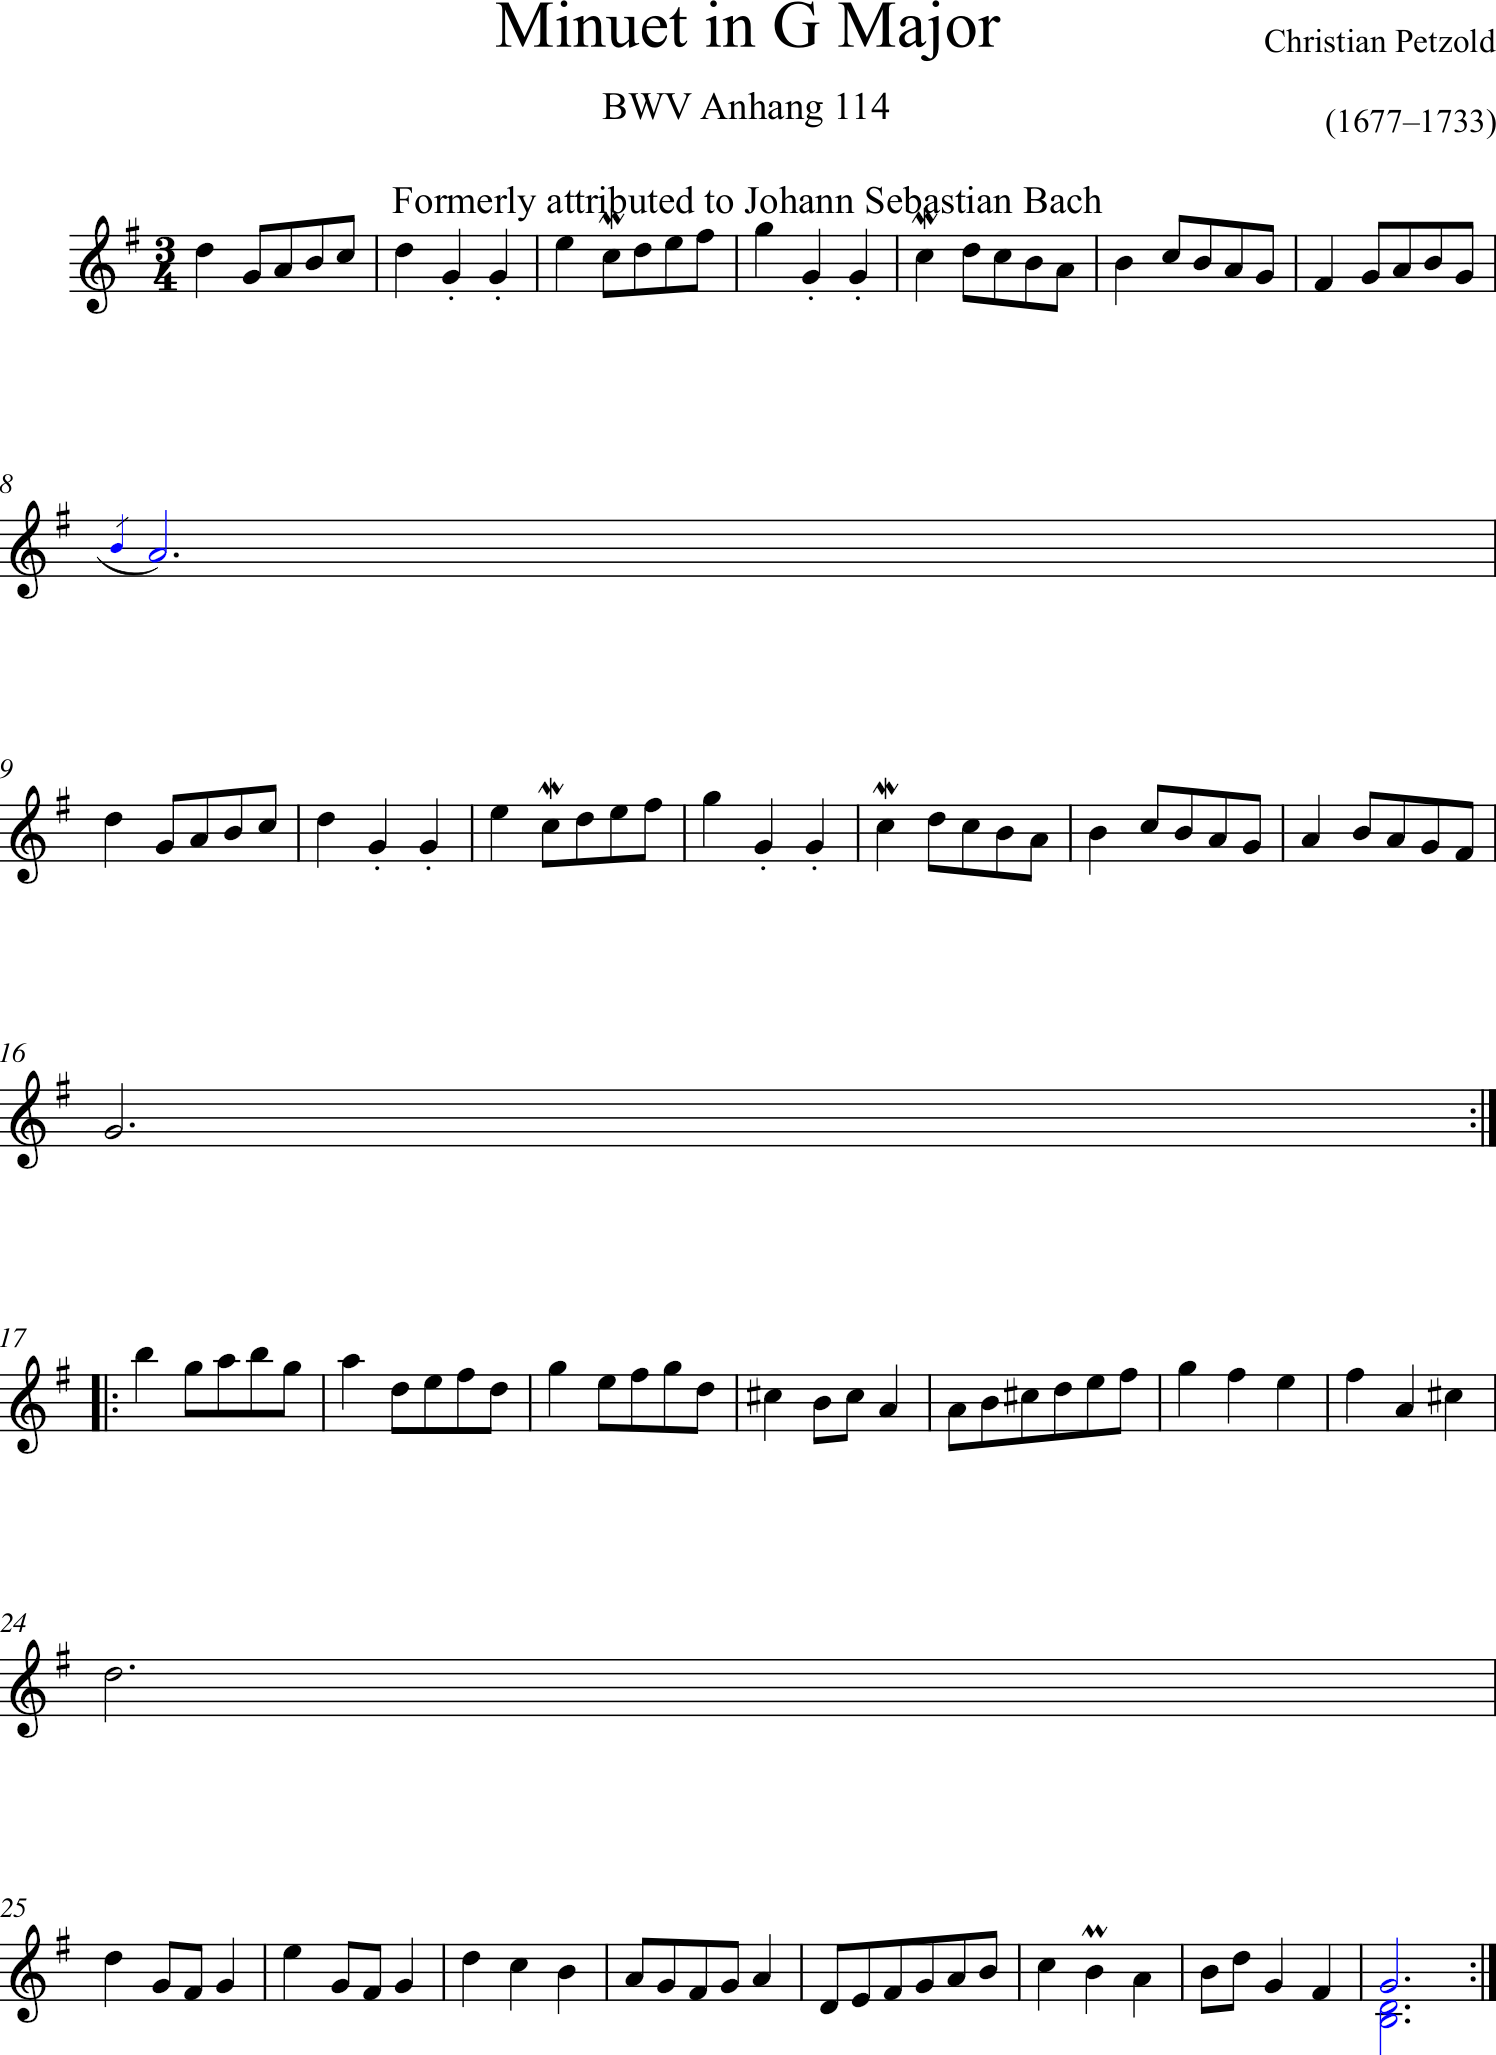

In [19]:
color_stream(score).show()